# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [39]:
# import pandas and numpy for data preprocessing and manipulation
import numpy as np
import pandas as pd


# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import module for splitting and cross-validation using gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# import metric to measure quality of model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import root_mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 

# import time series split
from sklearn.model_selection import TimeSeriesSplit


# import statistics models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# import machine learning models
from sklearn.linear_model import LinearRegression # import linear regression algorithm
from sklearn.ensemble import RandomForestRegressor # import random forest algorithm
from lightgbm import LGBMRegressor # import lightgbm regressor
from xgboost import XGBRegressor # import xgboost regressor
from sklearn.neighbors import KNeighborsRegressor 

In [40]:
#pip install scikit-learn==1.3.1 --user

In [41]:
import sklearn
import xgboost
print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)

Scikit-learn version: 0.24.1
XGBoost version: 1.5.1


In [42]:
# read the data
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [44]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Preparation

In [45]:
# For time series data, datetime column should be the table index and we can see it already is. 
# There are also no null values 
# Check dates are in chronological order 
print(df.index.is_monotonic_increasing) # Since the attribute returned "True", that means the order is chronological!


True


In [46]:
# Look at start and end dates
print('Minimum timestamp', df.index.min())
print()
print('Maximum timestamp', df.index.max())

# earliest start date is March 1st and end date is August 31st

Minimum timestamp 2018-03-01 00:00:00

Maximum timestamp 2018-08-31 23:50:00


In [47]:
df.head(10)
# The time is in increments of 10 minute intervals

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


I will resample the data into 1-hour intervals by aggregating every 10-minute segment within each hour. The most appropriate aggregation method is the sum, as Sweet Lift Taxi aims to predict the total number of taxi orders per hour. The company is not concerned with the number of orders every 10 minutes but instead prefers a view of demand on an hourly basis to better inform operational decisions.

In [48]:
df = df.resample('1h').sum()
df = df.rename(columns = {'num_orders': 'num_orders_hourly'})
df

,num_orders_hourly
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Analysis

In [49]:
# Summary statistics -look at distribution of data 
df.describe()

,num_orders_hourly
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


On average, there are about 84 taxi rides ordered every hour, with a standard deviation of 45. 

The mean is pretty similar to the median, 78 taxi rides ordered every hour, but since the mean is larger, that suggests the data is right skewed, which may suggest outliers. 

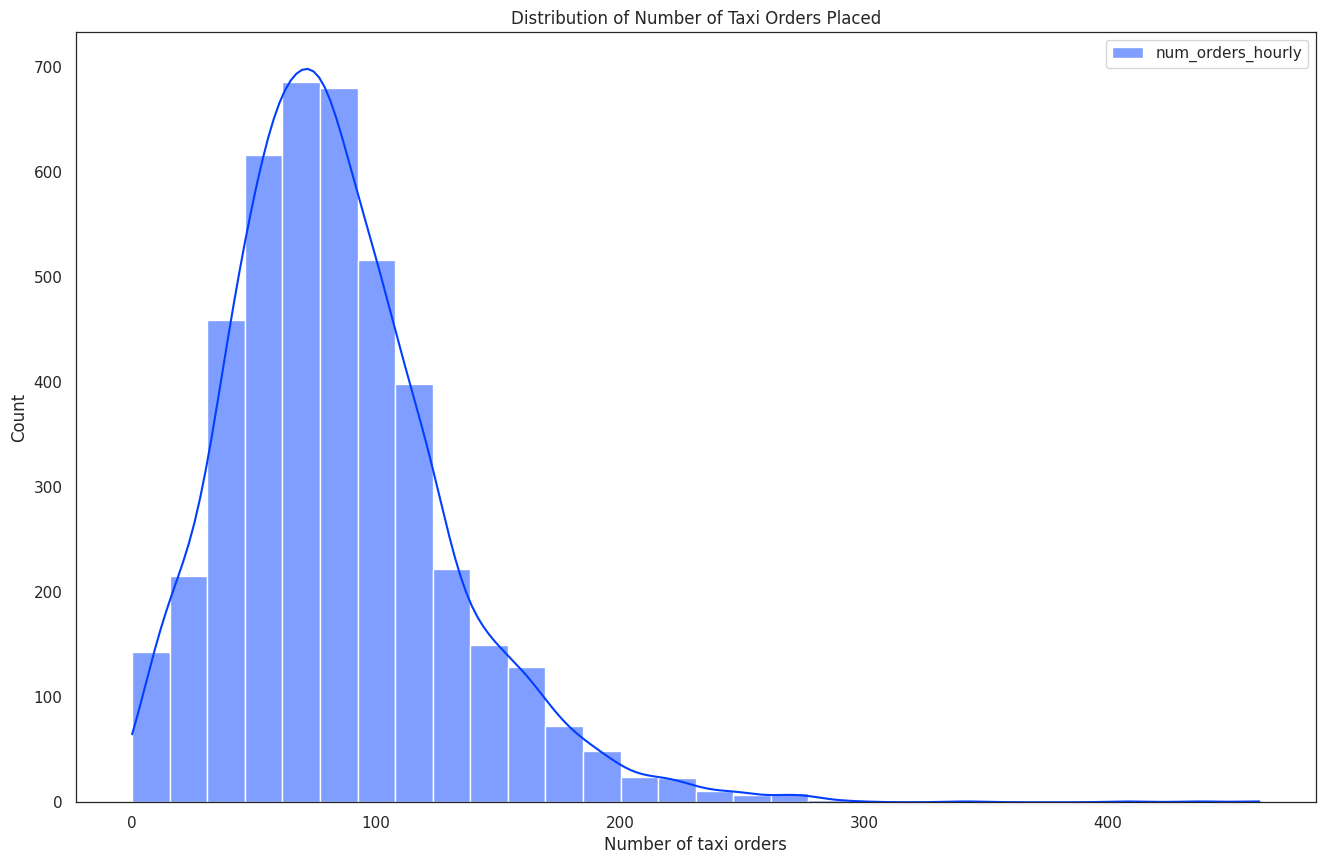

In [50]:
# Histogram 

# Set style
sns.set(style="white", palette="bright")
plt.rcParams['axes.linewidth'] = 0.9 #border thickness

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 10)) #creates one figure for multiple subplots #ax multiple plots multiple datasets (all plots drawn on same axis)

# Plot histograms 
sns.histplot(df, bins=30, ax=ax, kde=True, color= 'orange', legend=True)

# title and legend
#ax.set_title('Distribution of Number of Taxi Orders Placed')
ax.set(xlabel="Number of taxi orders", title="Distribution of Number of Taxi Orders Placed")
#ax.legend() #add labels to plot


plt.show()

##### Time series plots


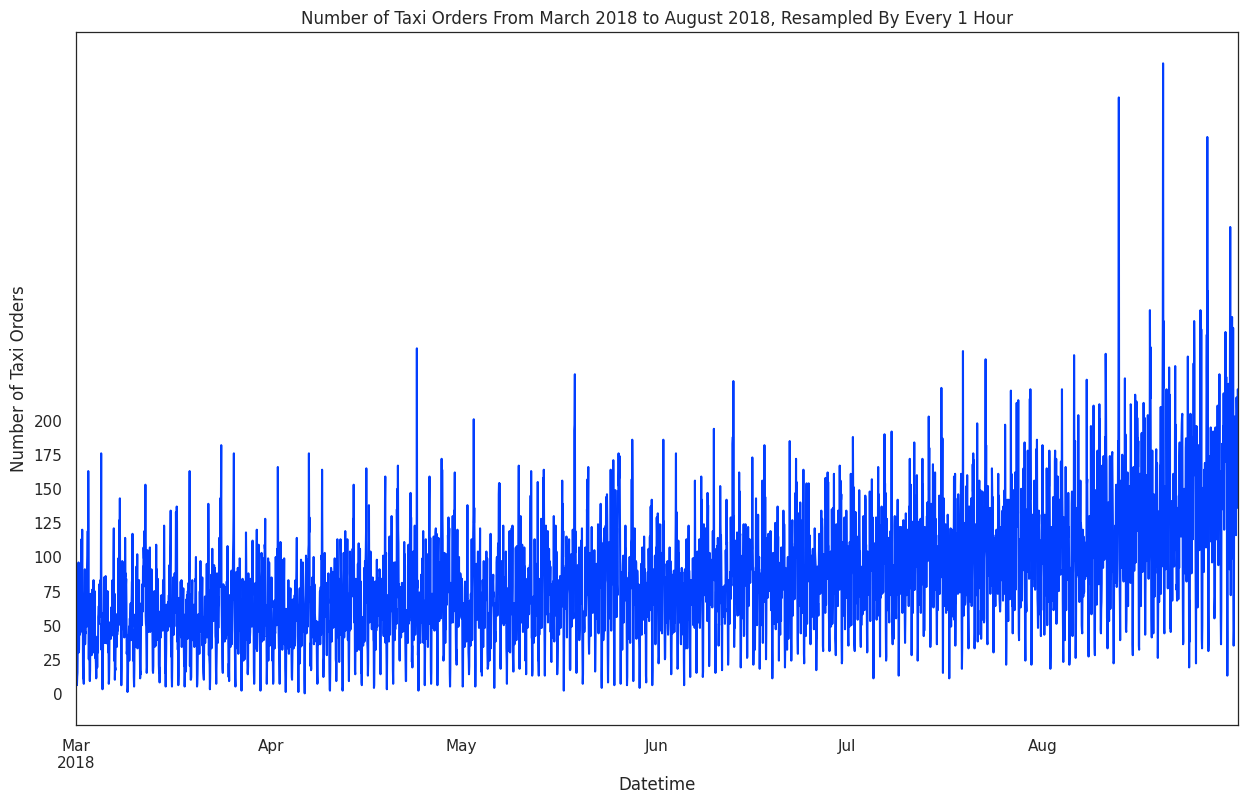

In [51]:
df.plot(figsize = (15, 9), legend = False)
plt.title('Number of Taxi Orders From March 2018 to August 2018, Resampled By Every 1 Hour')
plt.xlabel('Datetime')
plt.ylabel('Number of Taxi Orders')
plt.yticks(np.arange(0, 225, 25))


plt.show()

There is an upward trend in the number of taxi orders as the graph goes from March 2018 to August 2018.  The trend seems to be relatively constant from March to the June, but from July the number of taxi orders increases. July and August are the summer months, so there may be more travel during these months. 

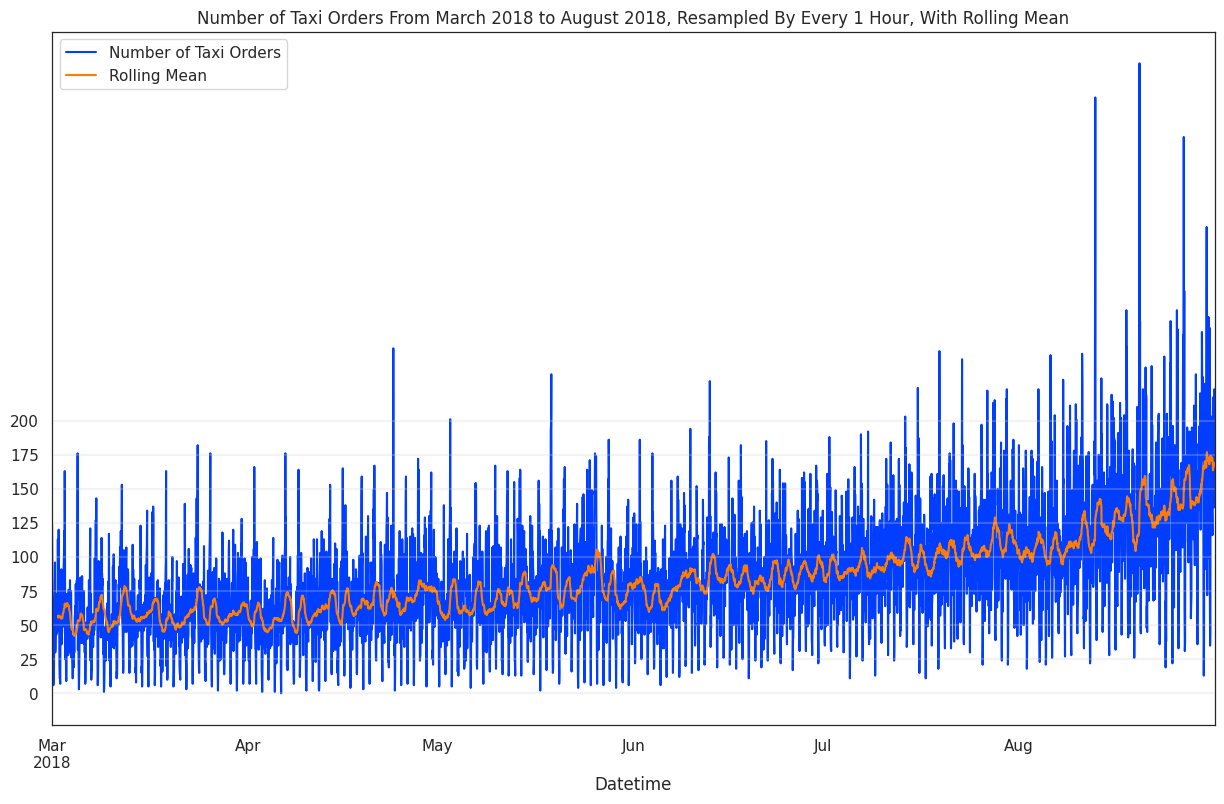

In [52]:
## Rolling average 

df['rolling_mean'] = df.rolling(24).mean() 

df.plot(figsize = (15, 9))

plt.legend(['Number of Taxi Orders', 'Rolling Mean'])
plt.title('Number of Taxi Orders From March 2018 to August 2018, Resampled By Every 1 Hour, With Rolling Mean')
plt.xlabel('Datetime')
plt.yticks(np.arange(0, 225, 25))

for y_tick in plt.gca().get_yticks():
    plt.axhline(y = y_tick, color = 'lightgray', linestyle = '-', alpha = 0.25)

plt.show()


The Rolling mean does not make it any clearer that there is an upward trend.

In [53]:
df

,num_orders_hourly,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN
...,...,...
2018-08-31 19:00:00,136,167.541667
2018-08-31 20:00:00,154,168.041667
2018-08-31 21:00:00,159,166.416667


In [54]:
df.drop('rolling_mean', axis=1, inplace=True)


In [55]:
df

,num_orders_hourly
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [56]:
# Check if time series is stationary or nonstationary
# Using augmented Dickey-Fuller (adfuller) unit root test 

train, test = train_test_split(df, shuffle = False, test_size = 0.1)

df_stationarityTest = adfuller(train, autolag = 'AIC')
print("P-value: ", df_stationarityTest[1])


P-value:  0.0007322730527364293


The p-value is less than 0.05, it is very likely that the dataset is stationary.

Text(0.5, 1.0, 'Trend')

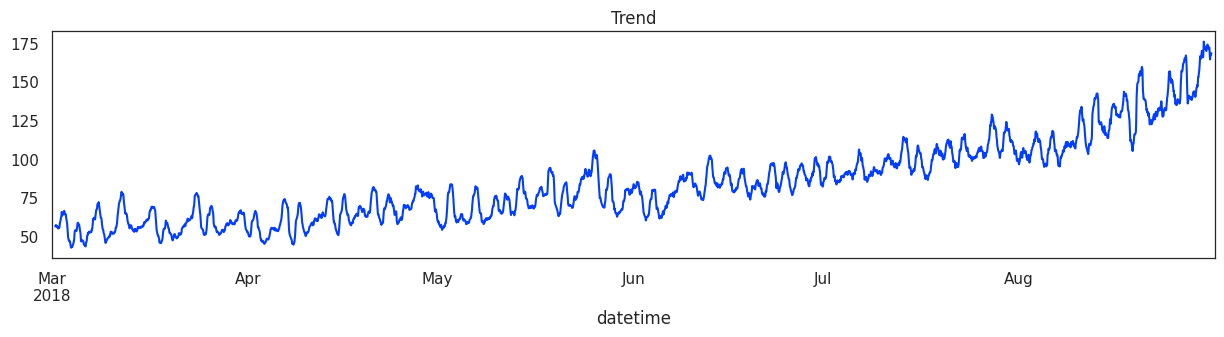

In [57]:
### Trends and seasonality

decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Trend')

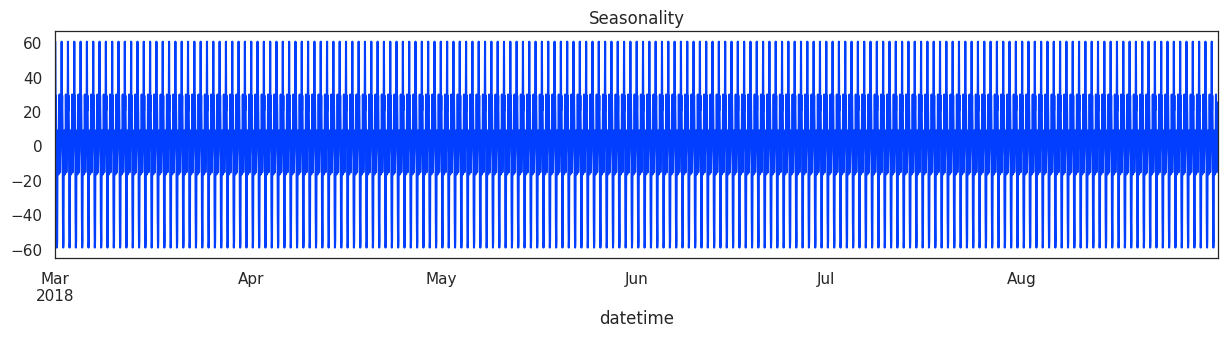

In [58]:
# Seasonality
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 10))
plt.title('Seasonality');

## Training

#### Feature engineering

In [59]:
df

,num_orders_hourly
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [60]:
# Create features, namely calendar features, lag features, and the rolling mean. 

# function to make new features 
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders_hourly'].shift(lag) # Adds lag features (previous values of the target variable)

    data['rolling_mean'] = data['num_orders_hourly'].shift().rolling(rolling_mean_size).mean()
    
# make new features 
df2 = pd.DataFrame(df)
make_features(df2, 6, 7)
df2.head()

,num_orders_hourly,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [61]:
# drop NaNs values 
df2 = df2.dropna()
print('The time series has', df2.shape[0], 'rows and', df2.shape[1], 'features')
print()
df2.head()

The time series has 4409 rows and 12 features



,num_orders_hourly,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,58.142857
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,42.571429
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,6.0,43.0,66.0,35.285714
2018-03-01 10:00:00,64,3,1,3,10,69.0,34.0,15.0,12.0,6.0,43.0,35.000000
2018-03-01 11:00:00,96,3,1,3,11,64.0,69.0,34.0,15.0,12.0,6.0,34.714286


In [62]:
# Splitting data with no shuffling to keep time order 
train, test = train_test_split(df2, shuffle=False, test_size=0.1)

In [63]:
# Seperate taregt and features 

features_train = train.drop(['num_orders_hourly'], axis=1)
target_train = train['num_orders_hourly']
features_test = test.drop(['num_orders_hourly'], axis=1)
target_test = test['num_orders_hourly']


In [64]:
# Time series cross validation set up
# TimeSeriesSplit avoids data leakage by ensuring each split only contains past data to predict future data.

tscv = TimeSeriesSplit(n_splits=5)


In [65]:
# Model pipeline 


pipe_linear = Pipeline([('scaler2', StandardScaler()),
                       ('LinearRegression(Dummy)', LinearRegression())])

pipe_rfr = Pipeline([('scaler1', StandardScaler()),
                    ('RandomForestRegressor', RandomForestRegressor(n_estimators=100))])

pipe_lgbm_r =  Pipeline([('scaler4', StandardScaler()),
                       ('LGBMRegressor', LGBMRegressor())])

pipe_xgb_r = Pipeline([('scaler5', StandardScaler()),
                       ('XGBRegressor', XGBRegressor())])

pipe_neighbors = Pipeline([('scaler6',StandardScaler()),('KNeighborsRegressor',KNeighborsRegressor())])


In [66]:
#Precheck models to see what models might be worth fine tuning 

#Creating list of pipelines.
pipelines = [pipe_rfr, pipe_linear, pipe_lgbm_r, pipe_xgb_r,pipe_neighbors]
#Creating a dictionary of pipelines.
pipe_dict = {pipe_rfr:'RandomForestRegressor', pipe_linear:'LinearRegression',\
              pipe_lgbm_r: 'LGBMRegressor', pipe_xgb_r:'XGBRegressor',pipe_neighbors:'KNeighborsRegressor'}


#### Hyperparameter tuning

In [67]:
# Random Forest 
# each block below uses GridSearchCV to find the best hyperparameters for each model

# hyperparameter grid
rfr_param = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [None, 2, 4, 8, 10, 12]
}

# RF regressor
rfr =  RandomForestRegressor(random_state=0, criterion='mse')

# GridSearch
RF_grid = GridSearchCV(
    estimator=rfr,
    param_grid=rfr_param,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1 # used to speed things up
)

# Fit model
RF_grid_model = RF_grid.fit(features_train, target_train)


print("Best Estimator:\n", RF_grid_model.best_estimator_)
print("\nBest Score (Negative RMSE):", RF_grid_model.best_score_)


Best Estimator:
 RandomForestRegressor(random_state=0)

Best Score (Negative RMSE): -25.363679873929755


In [68]:
print('The best hyperparameters are: {}'.format(RF_grid_model.best_params_))

The best hyperparameters are: {'max_depth': None, 'n_estimators': 100}


In [69]:
# XGBRegressor

# Define hyperparameter grid
xgb_param = {
    'learning_rate': [0.001, 0.01, 0.1, 0.3],
    'n_estimators': [10, 25, 50, 100],
    'base_score': [0.25, 0.5, 0.75]
}

#  XGBoost Regressor
xgb = XGBRegressor()

# GridSearchCV
XGB_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


XGB_grid_model = XGB_grid.fit(features_train, target_train)


print("Best Estimator:\n", XGB_grid_model.best_estimator_)
print("\nBest Score (Negative RMSE):", XGB_grid_model.best_score_)


Best Estimator:
 XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Best Score (Negative RMSE): -26.153996256285915


In [70]:
print('The best hyperparameters are: {}'.format(XGB_grid_model.best_params_))

The best hyperparameters are: {'base_score': 0.75, 'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
# # LGBM Regressor

# Define hyperparameter grid
lgbm_param = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 500],
    'num_leaves': [5, 10, 20, 31]
}

# LightGBM Regressor
lgbm = LGBMRegressor()

# GridSearchCV
LGBM_grid = GridSearchCV(
    estimator=lgbm,
    param_grid=lgbm_param,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1  # changed to -1 to use all cores
)

LGBM_grid_model = LGBM_grid.fit(features_train, target_train)


print("Best Estimator:\n", LGBM_grid_model.best_estimator_)
print("\nBest Score (Negative RMSE):", LGBM_grid_model.best_score_)


In [ ]:
print('The best hyperparameters are: {}'.format(LGBM_grid_model.best_params_))

In [ ]:
# K nearest neighbors

# hyperparameter grid
knn_param = {
    'n_neighbors': range(1, 5),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# KNN Regressor
knn = KNeighborsRegressor()

# GridSearchCV
knn_grid = GridSearchCV(
    estimator=knn,
    param_grid=knn_param,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1  # switched from 1 to -1 for parallel processing
)

# fitting model
knn_grid_model = knn_grid.fit(features_train, target_train)


print("Best Estimator:\n", knn_grid_model.best_estimator_)
print("\nBest Score (Negative RMSE):", knn_grid_model.best_score_)


In [ ]:
print('The best hyperparameters are: {}'.format(knn_grid_model.best_params_))

Several different algorithms with various hyperparameters were trained. The metric used to evaluate the model is the RMSE score. The KNeighbors regression algorithm had the worst RMSE score of 33.5. The LightGBM regressor had the best RMSE score of 25.2 and will be chosen for model testing for this task.

## Testing

In [ ]:

# Define pipeline
dummy_test_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit model on training data
dummy_test_model.fit(features_train, target_train)

# Predict on test data
dummy_predictions_test = dummy_test_model.predict(features_test)

rmse = mean_squared_error(target_test, dummy_predictions_test, squared=False)
print("Model MSE for the test set:", rmse)


In [ ]:

# Define pipeline with scaling + LightGBM
lgbm_test_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LGBMRegressor(learning_rate=0.1, n_estimators=200, num_leaves=10))
])

# Fit model on training data
lgbm_test_model.fit(features_train, target_train)


lgbm_predictions_test = lgbm_test_model.predict(features_test)


rmse = mean_squared_error(target_test, lgbm_predictions_test, squared=False)
print("Model MSE for the test set:", rmse)


#### Conclusion

The model with the best RMSE score, LightGBM, was chosen for model testing for this task and compared aginst a simple regression model. Using the LightGBM algorithm, an RMSE score of 44.08 was obtained for the test set and this model does better than the baseline linear regresison model (RMSE=52.74)